In [5]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import pandas as pd
import matplotlib as plt
from wordcloud import WordCloud
import string
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk 
import gc
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Dataset  solicitudes de informacion (INFOMEX)
Infomex es una plataforma en la cual se pueden realizar solicitudes de documentos o información al gobierno federal o al resto de los poderes, tanto legislativo como judicial.
La plataforma además nos proporciona, registros de todas las peticiones que se han hecho en un intervalo de 2003 hasta 2019.
El propósito de este proyecto es, realizar un análisis para contestarnos las pregunta, ¿que pregunta la gente al gobierno?, ¿cuales son algunos temas de interes a saber por parte de la poblacion? ¿podemos descubrir temas en tendencia respecto a algunos años?.
Puntos a tomar en cuenta.
* solo nos proporcionan preguntas referentes a datos publicos.
* No todas las solicitudes de las personas están escritas con alta profesionalidad.
* No todas las preguntas han sido respondidas satisfactoriamente.
* Únicamente nos concentraremos en procesar la información, limpiarla y generar gráficas de Word cloud.

numero total de solicitudes = 2,097,115

In [33]:
#Para mostrar todos los features del dataset, ocuparemos como ejemplo el documento del año 2015

path = 'C:/Users/oscar/Desktop/Denue/csv/Solicitudes2015.csv'# Cargamos los datos
df = pd.read_csv(path, low_memory =False, encoding= 'iso-8859-1')
df.DESCRIPCIONSOLICITUD=df.DESCRIPCIONSOLICITUD.astype(str)#para evitar problemas de tipo de dato
df.head()

,FOLIO,FECHASOLICITUD,DEPENDENCIA,ESTATUS,MEDIOENTRADA,TIPOSOLICITUD,DESCRIPCIONSOLICITUD,OTROSDATOS,ARCHIVOADJUNTOSOLICITUD,MEDIOENTREGA,...,ARCHIVORESPUESTA,FECHARESPUESTA,PAIS,ESTADO,MUNICIPIO,CODIGOPOSTAL,SECTOR,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,'1857500002315,01/01/2015 07:37,PEMEX EXPLORACIÓN Y PRODUCCIÓN,Terminada,Electrónica,Información Pública,Por separado de cada una de las infraestructu...,NaN,NaN,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,05/03/2015,México,Distrito Federal,BENITO JUAREZ,3100,Energía,NaN,NaN,NaN
1,'1857700000415,01/01/2015 07:41,PEMEX GAS Y PETROQUÍMICA BÁSICA,Terminada,Electrónica,Información Pública,FOLIO 1857500002315: Por separado de cada una...,NaN,NaN,Entrega por Internet en el INFOMEX,...,NaN,07/01/2015,México,Distrito Federal,BENITO JUAREZ,3100,Energía,NaN,NaN,NaN
2,'0064100023715,01/01/2015 07:48,INSTITUTO MEXICANO DEL SEGURO SOCIAL,Terminada,Electrónica,Datos Personales,DESCRIPCIÓN SOLICITUD,OTROS DATOS,NaN,Entrega por Internet en el INFOMEX,...,ADJUNTO,06/01/2015,México,Distrito Federal,MIGUEL HIDALGO,11280,Aportaciones a Seguridad Social,NaN,NaN,NaN
3,'2010000000315,01/01/2015 11:37,INSTITUTO NACIONAL DE LA ECONOMÍA SOCIAL (INAE...,Terminada,Electrónica,Información Pública,Solicito por este medio me proporcionen el man...,Dicho manuel interno de procedimientos es util...,NaN,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,09/01/2015,México,Oaxaca,OAXACA DE JUAREZ,68050,Economía,NaN,NaN,NaN
4,'2010000000415,01/01/2015 11:42,INSTITUTO NACIONAL DE LA ECONOMÍA SOCIAL (INAE...,Terminada,Electrónica,Información Pública,Solicito por medio de este medio me proporcion...,Solicito me proporcione las convocatorias públ...,NaN,Entrega por Internet en el INFOMEX,...,https://www.infomex.org.mx/gobiernofederal/mod...,09/01/2015,México,Oaxaca,OAXACA DE JUAREZ,68050,Economía,NaN,NaN,NaN


In [44]:
 print('En el Año 2015 se realizaron %s peticiones.' % (df.shape[0])) #tamaño del dataset

En el Año 2015 se realizaron 156183 peticiones.


In [35]:
#Obtenermos solo la columna que nos interesa.
df_peticiones = df[['DESCRIPCIONSOLICITUD']]
df_peticiones.head()

,DESCRIPCIONSOLICITUD
0,Por separado de cada una de las infraestructu...
1,FOLIO 1857500002315: Por separado de cada una...
2,DESCRIPCIÓN SOLICITUD
3,Solicito por este medio me proporcionen el man...
4,Solicito por medio de este medio me proporcion...


### Creacion de funciones previas.
Para realizar análisis de texto, tenemos que tener nuestros datos limpios para así, poder obtener la información mas útil y sin errores. los pasos básicos para hacer un procesamiento de lenguaje natural, son los siguientes.


#### Todos los textos, a minusculas.

In [36]:
def to_lowercase(s):
    lower_text = s.lower()
    return lower_text
df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(to_lowercase))

#### Eliminar puntuaciones.

In [37]:
#Funcion para eliminar las puntuaciones
def del_punctuation(s):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub('', str(s))
df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(del_punctuation))

Para este caso nos sera util tokenizar las peticiones de texto para asi realizar funciones como eliminarion de palabras irrelevantes

In [38]:
def word_tokenize(text):
        return nltk.word_tokenize(text)
    
df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(word_tokenize))

#### Eliminar Palabras irrelevantes.
Para el análisis hay palabras que tienden a aparecer mucho en los textos pero no indican información muy útil, tales como afirmaciones, conectores o saludos. por ello deben ser eliminadas.

In [39]:
def remove_trashwords(text, other_words=[]):
    list_new_stopwords = ['descripción', 'solicitud','solicito','informacion','información','año','ver', 'fecha','saber'
                          ,'si','datos','cada','gustaria','asi','así', 'dicho']
    list_new_stopwords.extend(other_words)# si queremos agregar mas stopwords desde la funcion
    stop_words = set(stopwords.words('Spanish'))
    stop_words.update(list_new_stopwords)
    words = [w for w in text if w not in stop_words]
    return words
df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(remove_trashwords))

Hasta aqui ya hemos hecho una limpieza basica de las solicitudes, ahora detokenizaremos las peticiones y las uniremos para obtener un texto plano.

In [40]:
def detokenize(text_list):
    return TreebankWordDetokenizer().detokenize(text_list)
df_peticiones['DESCRIPCIONSOLICITUD'] = df_peticiones['DESCRIPCIONSOLICITUD'].apply(detokenize)
df_peticiones.head(5)

,DESCRIPCIONSOLICITUD
0,separado infraestructuras construidas lasque c...
1,folio 1857500002315 separado infraestructurasc...
2,
3,medio proporcionen manual interno deprocedimie...
4,medio medio proporcionen calendarios deconvoca...


Ya teniendo este texto plano volveremos a tokenizar el texto y utilizaremos funciones propias de nltk para ver las palabras mas comunes,
no usamos tecnicas como vectorizacion de textos porque saturariamos la memoria rapidamente, puesto que obtendriamos matrices extremandamente grandes.


In [41]:
txt = df_peticiones.DESCRIPCIONSOLICITUD.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')

In [42]:
#tokenizamos todo el texto
words =nltk.word_tokenize(txt)
#freqDist nos da la ocurrencia de cada la pabra en eltexto
word_dist = nltk.FreqDist(words)


Tenemos que las palabras mas comunes en las peticiones, son:

In [43]:
word_dist.most_common(20)

[('2015', 37997),
 ('2014', 31047),
 ('número', 25278),
 ('copia', 23277),
 ('federal', 20645),
 ('1', 20388),
 ('2013', 17475),
 ('servicios', 16983),
 ('nacional', 16818),
 ('nombre', 15574),
 ('dependencia', 15390),
 ('pública', 14996),
 ('cv', 14298),
 ('2', 14267),
 ('solicita', 13561),
 ('ley', 13550),
 ('sa', 13520),
 ('general', 13207),
 ('servicio', 13174),
 ('informe', 12700)]

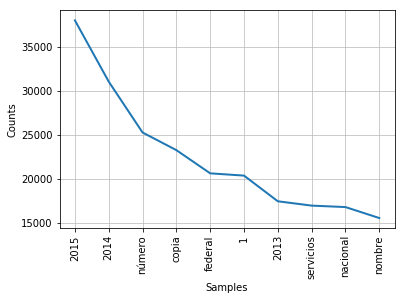

In [13]:
word_dist.plot(10)

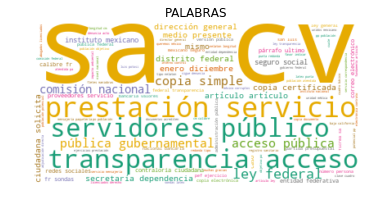

In [14]:
wc = WordCloud( background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6,3]
 
# Create subplots for each anio

wc.generate(txt)
wc.to_file("test_image.png")
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('PALABRAS')
plt.show()

 ## Hasta aquí tenemos la solución para un año, el siguiente código, hará el proceso anterior para cada uno de los años y nos generara la imagen del word cloud.

In [15]:

# Path de los CSV
mycsvdir = 'C:/Users/oscar/Desktop/Denue/csv'
# Obtenemos todos los .csv de ese directorio
csvfiles = glob.glob(os.path.join(mycsvdir, '*.csv'))
dataframes ={'año':[],
            'contenido':[]}
for file in csvfiles:
    df = pd.read_csv(file,low_memory =False, encoding= 'iso-8859-1',usecols =['DESCRIPCIONSOLICITUD'])
    df.DESCRIPCIONSOLICITUD=df.DESCRIPCIONSOLICITUD.astype(str)
    año = file[-8:][:4] # en el path de los archivos obtenemos el año ejemplo de path
    dataframes['año'].append(año)
    dataframes['contenido'].append(df.DESCRIPCIONSOLICITUD)


superFuncion se encarga de hacer todos los pasos anteriores para la limpieza de los textos, vemos que manda a llamar las funciones hechas arriba y nos retorna un WordCloud y guarda la imagen del wordcloud en el directorio.

In [16]:

def superFuncion(df_peticiones, año, file_image= True):
    df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(to_lowercase))
    df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(del_punctuation))
    df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(word_tokenize))
    df_peticiones=pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(remove_trashwords))
    df_peticiones['DESCRIPCIONSOLICITUD'] = df_peticiones['DESCRIPCIONSOLICITUD'].apply(detokenize)
    txt = df_peticiones.DESCRIPCIONSOLICITUD.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    wc = WordCloud( background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
    wc.generate(txt)
    if file_image == True:
        wc.to_file("%s.png" %(año))
    return  wc, txt



In [17]:
dff = pd.DataFrame(dataframes)
#dff.loc[dff['año']=='2004']['contenido'][1] forma de acceder  a los datos

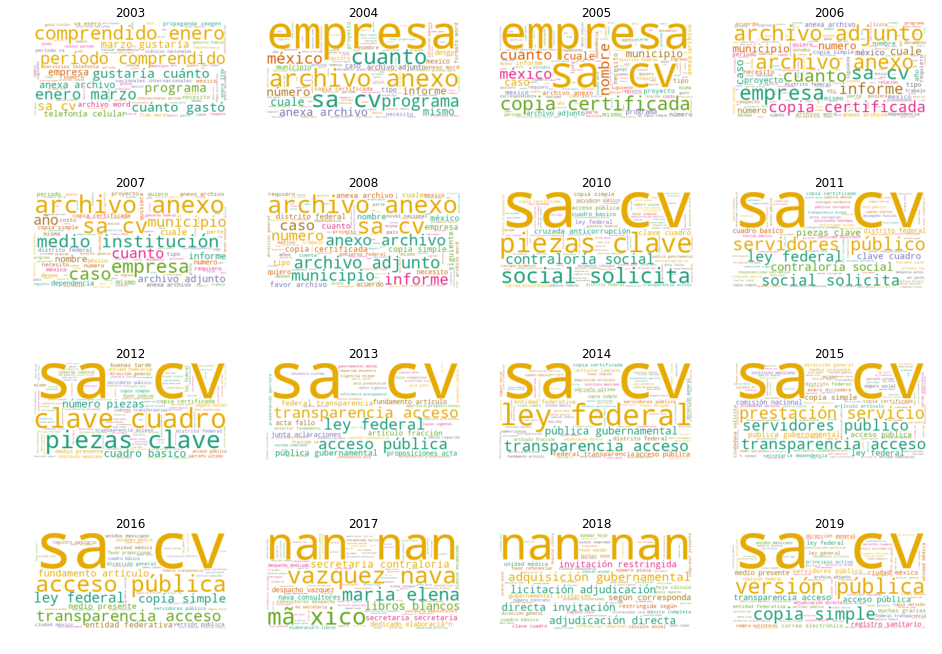

In [18]:
#para cada dataframe por año, plotearemos su wordcloud.
indexl=1
for index, row in dff.iterrows():
    año =row['año']
    temp_df = pd.DataFrame(row['contenido'])
    
    wc = superFuncion(temp_df,año)[0] #limpiamos los datos con superFunction y obtenemos el primer indice.
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [16,12]

    plt.subplot(4, 4, indexl)
    indexl+=1
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(año)
plt.show()

## Conclusiones


Podemos ver que existe una gran coincidencia en los últimos años, los cuales muestran como resultado, que las palabra mas concurrente es'SA CV' refiriéndose a las sociedades anónimas. como el impacto  de esas palabras es bastante alto, nos encargaremos de analizar una ves mas el fenómeno de las ocurrencias de las sociedades anónimas, osea.
haremos otro word cloud ahora solo con las preguntas que contengan el texto 'SA CV'.

In [42]:
#Para no depender de los datos anteriores, puesque que cargarlos puede ser muy tardado, lo haremos aparte
sa_cv_df =pd.read_csv('C:/Users/oscar/Desktop/Denue/csv\solicitudes2015.csv', low_memory =False, encoding= 'iso-8859-1')

In [43]:
sa_cv_df= pd.DataFrame(sa_cv_df.DESCRIPCIONSOLICITUD) #mantenemos el dataset como un dataframe y nos aseguramos que los campos sean str
sa_cv_df.DESCRIPCIONSOLICITUD=sa_cv_df.DESCRIPCIONSOLICITUD.astype(str)

In [44]:
pd.set_option('display.max_colwidth', -1) #muestra el texto completo de cada fila de DescripcionSolicitud
sa_cv_df.head()


,DESCRIPCIONSOLICITUD
0,Por separado de cada una de las infraestructuras construidas y de lasque están en construcción para manejar el gas producido y el utilizadoen el bombeo neumático en los campos activos o yacimientos en los quese inyecta nitrógeno solicito: 1.- Fecha de terminación de cadainfraestructura terminada y la estimada de las que están enconstrucción; 2.- Incluir la capacidad de manejo de gases en piescúbicos diarios el costo total de las terminadas y el costo estimadode las que están en construcción el costo diario de su operación elcosto actual del millar de pies cúbicos de nitrógeno producido y elcosto del millar de pies cúbicos del nitrógeno separado del gas totalproducido.
1,FOLIO 1857500002315: Por separado de cada una de las infraestructurasconstruidas y de las que están en construcción para manejar el gasproducido y el utilizado en el bombeo neumático en los campos activos oyacimientos en los que se inyecta nitrógeno solicito: 1.- Fecha determinación de cada infraestructura terminada y la estimada de las queestán en construcción; 2.- Incluir la capacidad de manejo de gases enpies cúbicos diarios el costo total de las terminadas y el costoestimado de las que están en construcción el costo diario de suoperación el costo actual del millar de pies cúbicos de nitrógenoproducido y el costo del millar de pies cúbicos del nitrógeno separadodel gas total producido.
2,DESCRIPCIÓN SOLICITUD
3,Solicito por este medio me proporcionen el manual Interno deProcedimientos utilizado en la modalidad INTEGRA correspondiente alInstituto Nacional de la Economía social esperando contar con unapronta respuesta quedo a sus apreciables órdenes.
4,Solicito por medio de este medio me proporcionen los calendarios deconvocatorias que se publicaran en este año 2015 por parte del InstitutoNacional de la Economía Social.


para que no tengamos problemas con buscar mayúsculas o minúsculas, pasaremos la función to lower_case y del_punctuation

In [45]:
sa_cv_df=pd.DataFrame(sa_cv_df.DESCRIPCIONSOLICITUD.apply(to_lowercase))
sa_cv_df=pd.DataFrame(sa_cv_df.DESCRIPCIONSOLICITUD.apply(del_punctuation))

In [46]:
sa_cv_df.shape

(156183, 1)

In [47]:
# Buscamos las rows las cuales contengan el texto 'cv'
CV_ = sa_cv_df.loc[sa_cv_df['DESCRIPCIONSOLICITUD'].str.contains('cv')]
print('numero de  rows que contengan el texto cv:',CV_.shape[0])


numero de  rows que contengan el texto cv: 9353


In [48]:
CV_.head()

,DESCRIPCIONSOLICITUD
61,solicito conocer con exactitud cuántas quejas han sido presentadas porlos consumidores ante la procuraduría federal del consumidor contra elproveedor radiomovil dipsa sa de cv mejor conocido como telcel específicamente en el período 1 de enero al 31 de diciembre del año2014 específicamente las que corresponden a las delegaciones profecodel estado de baja california la subdelegación mexicali bc y tambiénbaja california sur también conocer cuál es el detalle ó estatus queguarda cada una de estas quejas es decir si están conciliadas noconciliadas cerradas salvo los derechos desistidas satisfechas etcétera gracias
127,solicito se me indique respecto a la supervisión que la cnbv debiórealizar a ficrea sa de cv sfp lo siguiente 1 durante elfuncionamiento de ficrea sa de cv sfp cuáles fueron todos losactos de supervisión que la cnbv llevó a cabo respecto a la misma 2 seme proporcione en pdf la documentación que se generó derivada de lasupervisión realizada version publica 3 cuándo inició la cnbv lainvestigación que llevó a realizar la intervención de dicha sofipo y encaso de que no haya existido alguna investigación formal se me indiqueel acto por el cual se determinó intervenir a ficrea 4 qué actos enconcreto llevó a cabo la cnbv en dicha investigación 5 nombre de losfuncionarios que fueron los encargados en realizar la investigaciónreferida 6 el fundamento de la investigación realizada así como elfundamento de todos los actos que dentro de dicha investigación sedebieron de realizar
134,solicito copia simple y en versión pública de los documentos queintegraron la propuesta presentada por el consorcio formado porconstructora y edificadora gia a sa de cv promotora ydesarrolladora mexicana sa de cv constructora teya sa de cv ghpinfraestructura mexicana sapi de cv china railway constructioncorporation limited china railway construction corporationinternational limited china railway construction méxico sa de cv csr corporation limited para la licitación del tren méxicoquerétaro con números de folio siguiente 007867012107 012137012176012177013975 013976014002 014138014262 014403014556 014557014568 014569014693
136,solicito copia simple y en versión pública de los documentos queintegraron la propuesta económica presentada por el consorcio formadopor constructora y edificadora gia a sa de cv promotora ydesarrolladora mexicana sa de cv constructora teya sa de cv ghpinfraestructura mexicana sapi de cv china railway constructioncorporation limited china railway construction corporationinternational limited china railway construction méxico sa de cv csr corporation limited para la licitación del tren méxicoquerétaro con números de folio siguiente 000002000005 000006001005
140,copia completa del ultimo certificado de buenas prácticas de manufacturaotorgado a waltvick de méxico sa de cv


In [50]:
#Ahora eliminamos las palabras CA y CV de el dataframe
CV_=pd.DataFrame(CV_.DESCRIPCIONSOLICITUD.apply(word_tokenize))
CV_ = pd.DataFrame(CV_.DESCRIPCIONSOLICITUD.apply(remove_trashwords, args=[['sa', 'cv']]))
CV_['DESCRIPCIONSOLICITUD'] = CV_['DESCRIPCIONSOLICITUD'].apply(detokenize)
CV_ = pd.DataFrame(CV_.DESCRIPCIONSOLICITUD.apply(remove_numbers))
CV_= CV_.DESCRIPCIONSOLICITUD.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
wc = WordCloud( background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
wc.generate(CV_)

In [51]:
txt =CV_
words =nltk.word_tokenize(txt)
word_dist = nltk.FreqDist(words)


In [52]:
most_common = word_dist.most_common(10)
words = [x[0] for x in most_common]
frecuencys = [x[1] for x in most_common]


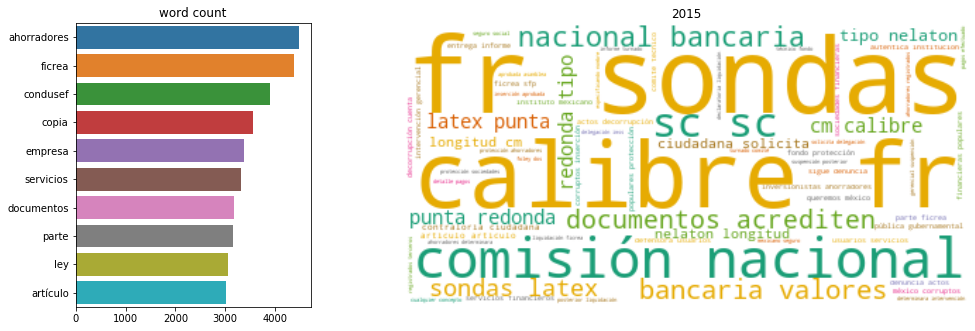

In [53]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
chart = sns.barplot(frecuencys,words,  orient ="h")
plt.title('word count')
plt.subplot(1,2,2)

  
plt.subplot(grid[0, 1:])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('2015')
plt.savefig('books_read.png')

Con eso podemos ver las tendencia de lo que la gente busca en cuanto sociedades anonimas. muchas preguntas hicieron referencia a ellas pero aun tenemos un problema, que estamos cerrandonos solo a este topico, nos gustaria tener mas topicos de interes en la poblacion, tendremos que usar tecnicas mas avanzadas y nuevos metodos para extraer información de las preguntas

## Ahora intentemos otra forma de obtener temas de interés en los datos, mediante una clusterizacion de texto usando K-MEANS + TF-IDF, cada cluster nos mostrara un punto de interés de la población en particular. lo cual indicara los distintos temas en los que esta interesada la población.

* no se utilizo cosine similarity puesto tenemos ram limitada

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd


###### Reutilizaremos el dataset cargado previamente
*  En este caso eliminaremos los numero dentro de los documentos

In [17]:
def remove_numbers(txt):
    txt = re.sub(" \d+", " ", txt)
    txt= ''.join([i for i in txt if not i.isdigit()])
    return txt

In [18]:
df_peticiones = pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(remove_numbers))
df_peticiones.head()

,DESCRIPCIONSOLICITUD
0,separado infraestructuras construidas lasque c...
1,folio separado infraestructurasconstruidas co...
2,
3,medio proporcionen manual interno deprocedimie...
4,medio medio proporcionen calendarios deconvoca...


In [19]:
vectorizer = TfidfVectorizer()
#obtendremos X como el vector TF-IDF de los datos
X = vectorizer.fit_transform(df_peticiones.values.ravel())
X

<156183x92706 sparse matrix of type '<class 'numpy.float64'>'
	with 3351020 stored elements in Compressed Sparse Row format>

In [20]:
true_k = 10 #numero de clusters
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [30]:
first_list=[]
for i in range(true_k):
    print("\n-------------Topic %d:\n"% i),
    for ind in order_centroids[i, :10]:
        first_list.append(terms[ind])
        print(" %s" % terms[ind],end =',')


-------------Topic 0:

 copia, número, federal, nombre, informe, nacional, solicita, cv, servicios, méxico,
-------------Topic 1:

 puesto, requisitadas, oficio, aprecia, vinculantes, facilitarme, ssfpdgor, descripciones, dictaminada, valuación,
-------------Topic 2:

 ultimo, párrafo, fundamento, presente, favor, abarcando, aclara, expide, tiempos, ninguna,
-------------Topic 3:

 pasivo, obligación, banca, contingente, desarrollo, cargo, pago, institución, incondicional, irrevocable,
-------------Topic 4:

 promociones, recomendaciones, pliegos, sancionatoria, observación, aclaración, instancia, desempeño, responsabilidad, administrativa,
-------------Topic 5:

 anexo, archivo, consultar, atenta, gracias, manera, mas, atención, solicita, favor,
-------------Topic 6:

 medicamento, compra, ultimo, párrafo, número, fundamento, real, presente, favor, almacén,
-------------Topic 7:

 reposición, orden, órdenes, entrega, incumplió, proveedor, favor, pertenece, solicita, dentilab,
-------

Aquí obtuvimos resultados bastante satisfactorios, pordemos interpretar que cada cluster es un tema de interes para la población. el problema que vemos aqui es que el modelo de K-Means no esta del todo optimizado, puesto que las preguntas estan muy esparcidas con lo cual quiza no tengamos los temas mas importantes.

## En este caso aplicaremos una tecnica mas avanzada para este tipo de situaciones:
* A Dirichlet Multinomial Mixture Model-based Approach for
    Short Text Clustering (GSDMM)
    
basado en el supuesto de que cada documento se muestrea por un solo tema, a diferencia de LDA que supone que en un texto hay multiples temas.
    

In [37]:
df_peticiones = pd.DataFrame(df_peticiones.DESCRIPCIONSOLICITUD.apply(word_tokenize))
# Utilizaremos los mismos datos que al principio de este notebook

data_train= df_peticiones.DESCRIPCIONSOLICITUD.values.ravel()

# elimanamos las cadenas vacias
data_cl = [x for x in data_train if x != []] 

vocab = set(x for doc in data_cl for x in doc)
V = len(vocab)
print('formato de entrada al modelo:')
data_cl[:1]

formato de entrada al modelo:


[['separado',
  'infraestructuras',
  'construidas',
  'lasque',
  'construcción',
  'manejar',
  'gas',
  'producido',
  'utilizadoen',
  'bombeo',
  'neumático',
  'campos',
  'activos',
  'yacimientos',
  'quese',
  'inyecta',
  'nitrógeno',
  'terminación',
  'cadainfraestructura',
  'terminada',
  'estimada',
  'enconstrucción',
  'incluir',
  'capacidad',
  'manejo',
  'gases',
  'piescúbicos',
  'diarios',
  'costo',
  'total',
  'terminadas',
  'costo',
  'estimadode',
  'construcción',
  'costo',
  'diario',
  'operación',
  'elcosto',
  'actual',
  'millar',
  'pies',
  'cúbicos',
  'nitrógeno',
  'producido',
  'elcosto',
  'millar',
  'pies',
  'cúbicos',
  'nitrógeno',
  'separado',
  'gas',
  'totalproducido']]

In [38]:
#En este caso obtendremos 6 grupos 
from gsdmm import MovieGroupProcess
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=30)


In [ ]:
mgp.fit(data_cl, V)

In [56]:
# Funcion para obtener las palabras mas relevantes en los clusters, notese que tambien los clusters estan ordenados
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print("------------------")
        

In [57]:
doc_count = np.array(mgp.cluster_doc_count)
print('Numero de documentos por cluster :', doc_count)
print('*'*20)
# Topics ordenado por el numero de documentos que tienen asignados
top_index = doc_count.argsort()[-10:][::-1]
print('Cluster mas importantes (por numero de documentos):', top_index)
print('*'*20)

top_words(mgp.cluster_word_distribution, top_index,10)

Numero de documentos por cluster : [29738  4596  6597  2536 23106 32206  3448  2274  5926 12313]
********************
Cluster mas importantes (por numero de documentos): [5 0 4 9 2 8 1 6 3 7]
********************
Cluster 5 : [('número', 5548), ('presupuesto', 4196), ('programa', 4024), ('personas', 3956), ('nacional', 3900), ('federal', 3485), ('años', 3403), ('méxico', 3285), ('monto', 2809), ('informe', 2704)]
------------------
Cluster 0 : [('copia', 5856), ('general', 3865), ('nombre', 3676), ('personal', 3529), ('nacional', 3449), ('federal', 3430), ('instituto', 3053), ('c', 3045), ('informe', 2744), ('número', 2712)]
------------------
Cluster 4 : [('copia', 5306), ('cv', 4679), ('sa', 4264), ('empresa', 3542), ('municipio', 3458), ('contrato', 3444), ('federal', 3099), ('número', 3031), ('méxico', 2574), ('proyecto', 2475)]
------------------
Cluster 9 : [('servicios', 9839), ('federal', 8281), ('servicio', 8041), ('artículo', 8034), ('dependencia', 7965), ('ley', 7124), ('copi

# Conclusiones Finales
A lo largo de este desarrollo se lograron conocer varias formas de obtener información relevante acerca de documentos, vemos como funcionan las distintas técnicas de extracción de datos, algunas gráficas y modelos mas avanzados como k means y gsdmm vemos como es distinto técnicas tan simples como contar la frecuencia de las palabras mas repetidas en los documentos como conceptos mas avanzados que no solo analizan la cantidad de palabras iguales en los documentos.
logramos entender en general algunos grupos de preguntas que se repiten en general y con ello descubrir en que esta interesada la población.
Se aprendieron múltiples temas los cuales son 
1.	Term frecuency.
2.	Word cloud.
3.	Word cloud anidados(no me juzguen).
4.	Word cloud and term frecuency.
5.  Topic models.
5.	K means.
6.	K means + TF-IDF.
7.	K mean + TF-IDF + cosine sImilarity.
8.	Latend dirichlet allocation.
9.	GSDMM.

Puntos a tener en cuenta.
* Algunos procesamientos pueden tomar mucha memoria y marcar errores de memoria
* Para los años 2017 y 2018, los datos en los archivos están mal ordenados
* El año 2009 esta dañado en su formato, por eso no fue agregado
* Al algoritmos de k means, no agregamos una matriz de cosine similarity entre los vectores, puesto que la memoria requerida supera lo que ofrece mi computadora.
* No hicimos hierarichal clustering pues su complejidad en tiempo es cuadrática, mientrasque K means tiene  complejidad lineal.
* No aplicamos el algoritmo de Latend Dirichled allocation por el tiempo de procesamiento y ese modelo esta dedicado para textos grandes.
